# 2. Train autoencoder

## 2.1 Set environment
For building the neural network, Keras is used as an interface to TensorFlow . Tensorflow (https://www.tensorflow.org/) is an open-source library for building neural network developed by Google. Keras (https://keras.io/) is an open-source python library providing a more high level and user-friendly interface to the Tensorflow backend. 
We load the Keras modules and set the location of the data file in the file variable.

In [1]:
import numpy as np
import keras
from keras import layers
from keras.models import save_model, load_model
from keras.callbacks import TensorBoard
from isoplot import isoplot
# Set location of data file
file="data/era20c.npy"

## 2.2 Create train, validate and test datasets
After randomizing the order of the data, the dataset is split in 3 parts:
- a train dataset for training the NN with 90% of the data
- a validation dataset, used to validate the model during training, with 5% of the data
- a test dataset, which is not used during training, to evaluate the model, with 5% of the data

In [2]:
# N is the size of the test and validation dataset
N = 2000
data = np.load(file)
i = np.argsort(np.random.random(data.shape[0]))
data = data[i]
test = data[:N//2]
validate = data[N//2:N]
train = data[N:]

## 2.3 Architecture of the neural network
We will use a convolute autoencoder neural network to compress our section of the ERA-20C dataset with the MSP and Z500 data. An autoencoder consits of 2 parts: an encoding and a decoding part. Alle convolution layers used are based on a 3x3 kernel, and so have 9 parameters to learn. Our input values are maps of 32x64 with 2 channels: MSP and Z500. The first convolutional layers keeps the spacial dimension, but increases the number of channels to 32. So this layer has 2x32 kernels, plus 32 biases, giving in total 608 parameters to learn. Convolutional layer are followed by 2x2 pooling layers, which are taking the maximum of the 4 grid points. Using these the spacial dimension is reduced by a factor 2. We use the convolute/pooling combination 3 times, going from 32x64 to 4x8. We also reduced the number of channels to 1. This give a total dimension reduction factor of 128, from 4096 to 32.

The decoding part is a "mirror" of the encoding part, using nearest neighbour upsampling layers instead of pooling layers. So the spacial dimension is multiplied by 2 for each upsampling layer. The model will be trained so that after compressing and decoding, the output is as close as possible to input. This is done by minimizing the mean square error  (MSE) over all gridpoint and channels between the output and input. The Adam optimizer is used, which is variant of the stochastic gradient descent algorithm. Rectified Linear Unit (ReLu) activation functions are used, except for the one preceding the MSE operator. Tuning has been done on the hyperparameters (type and numbers of layers, dimensions, channels, activation functions,...), but further improvement can probably be done.

In [3]:
# Encoder (32,64,2) - > (4,8,1)
input = keras.Input(shape=(32, 64, 2))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)

# Decoder (4,8,1) -> (32,64,2)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='MSE')
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 64, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 64, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 16, 16)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 16, 8)          1160  

2022-06-13 09:44:22.397873: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## 2.4 Start tensorboard
For following up the training the tensorboard is started. To access tensorboard, surf with your browser to port 6006.

In [4]:
%%bash
/bin/bash -c tensorboard --host 0.0.0.0 --logdir=/tmp/autoencoder 2> /dev/null &
#firefox 127.0.0.1:6006 &

## 2.5 Train the model
Here the model is trained. The epoch number is specifying how many cycles over the complete dataset are done. The batch size specifies after how many samples the parameters are updated by the back propagation algorithm. Dependent on the computer power, this step can take a while. Afterwards the model is saved in a hdf file.

In [5]:
autoencoder.fit(train, train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(validate, validate),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

autoencoder.save("data/autoencoder.h5")
#save_model(autoencoder,"model2")
#autoencoder.save_weights("data/weights2.h5")

Epoch 1/30
151/151 [==============================] - 85s 554ms/step - loss: 0.0096 - val_loss: 0.0034
Epoch 2/30
151/151 [==============================] - 82s 543ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 3/30
151/151 [==============================] - 84s 556ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 4/30
151/151 [==============================] - 82s 546ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/30
151/151 [==============================] - 83s 549ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/30
151/151 [==============================] - 83s 549ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/30
151/151 [==============================] - 84s 559ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/30
151/151 [==============================] - 83s 553ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/30
151/151 [==============================] - 82s 543ms/step - loss: 9.8796e-04 - val_loss: 9.5186e-04
Epoch 10/30
151/151 [==============================] - 83s 549ms/

## 2.6 Evaluate the model

In [6]:
score = autoencoder.evaluate(test, test, verbose=0)
print('Test loss:', score)

Test loss: 0.0007648785831406713


## 2.7 Compare the isoplots 

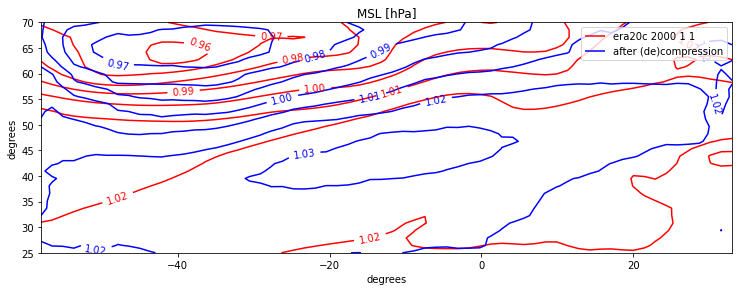

In [7]:
# set date "%Y %-m %-d"
date = "2000 1 1"

# load data
autoencoder = load_model("data/autoencoder.h5")
x = np.load(file)
dates = np.load("data/dates.npy")
zone = np.load("data/zone.npy")
scale = np.load("data/scale.npy")
date_index = np.where(dates == date)
x_in = x[date_index]

# compare output with input
x_out = autoencoder.predict(x_in) 
isoplot(x_in[0,:,:,0],x_out[0,:,:,0],"era20c "+date,"after (de)compression",zone,scale[0])